In [1]:
import pandas as pd                                      
import numpy as np                                       
import torch                                             
import torch.nn as nn                                    
from torch.utils.data import Dataset, DataLoader         
from sklearn.model_selection import train_test_split     
import sys                                               
                                                      
# Add the models directory to the python path            
sys.path.append('models')                                
from mlp_model import SimpleMLP                          

## Load and Explore Gene Expression Data

The counts data contains gene expression measurements for different drug treatments.

In [3]:
# Load metadata to get drug information
compounds = pd.read_csv("./data/unique_compounds.csv")
counts_df = pd.read_csv('./data/MCE_Bioactive_Compounds_HEK293T_10μM_Counts.csv', index_col=0, skiprows=1)
metadata_df = pd.read_csv('./data/MCE_Bioactive_Compounds_HEK293T_10μM_MetaData.csv', skiprows=1)
print(f"Number of samples: {len(metadata_df)}")
print(f"Number of genes: {counts_df.shape[1]}")
print(f"\nMetadata columns: {metadata_df.columns.tolist()}")
print(f"\nFirst few drug treatments:")
print(metadata_df[['treatment', 'sample']].head(10))

Number of samples: 40778
Number of genes: 3407

Metadata columns: ['unique_ID', 'experiment_no', 'sample_plate', 'sample_row', 'sample_column', 'cell_id', 'pert_itime', 'pert_idose', 'sample', 'treatment']

First few drug treatments:
   treatment     sample
0   HY_50946   HY_50946
1   HY_18686   HY_18686
2  HY_17592A  HY_17592A
3   HY_19411   HY_19411
4   HY_18522   HY_18522
5   HY_17439   HY_17439
6   HY_18061   HY_18061
7       DMSO    DMSO_03
8  HY_19928A  HY_19928A
9   HY_18669   HY_18669


In [37]:
metadata_df

,unique_ID,experiment_no,sample_plate,sample_row,sample_column,cell_id,pert_itime,pert_idose,sample,treatment
0,MCE5_293T_24H_X1:D10,MCE_20220606,MCE5_293T_24H_X1,4,10,cell_293T,24 h,10.0 uM,HY_50946,HY_50946
1,MCE5_293T_24H_X1:G14,MCE_20220606,MCE5_293T_24H_X1,7,14,cell_293T,24 h,10.0 uM,HY_18686,HY_18686
2,MCE5_293T_24H_X1:G22,MCE_20220606,MCE5_293T_24H_X1,7,22,cell_293T,24 h,10.0 uM,HY_17592A,HY_17592A
3,MCE5_293T_24H_X1:O22,MCE_20220606,MCE5_293T_24H_X1,15,22,cell_293T,24 h,10.0 uM,HY_19411,HY_19411
4,MCE5_293T_24H_X1:G08,MCE_20220606,MCE5_293T_24H_X1,7,8,cell_293T,24 h,10.0 uM,HY_18522,HY_18522
...,...,...,...,...,...,...,...,...,...,...
40773,MCE4_293T_24H_X3:P01,MCE_20221009_3,MCE4_293T_24H_X3,16,1,cell_293T,24 h,-666,Blank_42,Blank
40774,MCE4_293T_24H_X3:L21,MCE_20221009_3,MCE4_293T_24H_X3,12,21,cell_293T,24 h,10.0 uM,HY_13954,HY_13954
40775,MCE4_293T_24H_X3:P13,MCE_20221009_3,MCE4_293T_24H_X3,16,13,cell_293T,24 h,10.0 uM,HY_15414,HY_15414
40776,MCE4_293T_24H_X3:J23,MCE_20221009_3,MCE4_293T_24H_X3,10,23,cell_293T,24 h,-666,DMSO_02,DMSO


In [38]:
compounds

,Unnamed: 0,Ranking,Catalog Number,Score,Compound name,Treatment concentration,CAS Number,CID,CAS,smiles
0,0,1,HY_107369,0.367344,4-Butylresorcinol,10 μM,18979-61-8,205912.0,18979-61-8,CCCCC1=C(C=C(C=C1)O)O
1,9,3,HY_19747,0.345520,HPOB,10 μM,1429651-50-2,71532921.0,1429651-50-2,C1=CC=C(C=C1)N(CCO)C(=O)CC2=CC=C(C=C2)C(=O)NO
2,30,8,HY_11009,0.331873,CGP60474,10 μM,164658-13-3,644215.0,164658-13-3,C1=CC(=CC(=C1)Cl)NC2=NC=CC(=N2)C3=CC(=NC=C3)NCCCO
3,31,9,HY_12798C,0.329573,AR-13324 M1 metabolite,10 μM,2309668-15-1,134128281.0,2309668-15-1,C1=CC(=CC=C1CO)[C@@H](CN)C(=O)NC2=CC3=C(C=C2)C...
4,62,15,HY_122641B,0.311769,Deltasonamide 2 (TFA),10 μM,2235358-74-2,138454775.0,2235358-74-2,CNC1=NC=CC(=N1)CN(C2CCC(CC2)N)S(=O)(=O)C3=CC=C...
...,...,...,...,...,...,...,...,...,...,...
2514,49993,12336,HY_122614,-0.250347,S29434,10 μM,874484-20-5,46861897.0,874484-20-5,COC1=NC2=C(C=C1)N3CC4=C(C3=C2CCNC(=O)C5=CC=CO5...
2515,50000,12341,HY_13504,-0.253410,PIK-293,10 μM,900185-01-5,53245636.0,900185-01-5,CC1=C2C(=CC=C1)N=C(N(C2=O)C3=CC=CC=C3C)CN4C5=N...
2516,50018,12345,HY_13994,-0.255190,Mps1-IN-2,10 μM,1228817-38-6,44968267.0,1228817-38-6,CCOC1=C(C=CC(=C1)N2CCC(CC2)O)NC3=NC=C4C(=N3)N(...
2517,50023,12348,HY_135954A,-0.267305,PDK4-IN-1 (hydrochloride),10 μM,2310262-11-2,146026197.0,2310262-11-2,C1CNCCC1N2C=C(C=N2)C3=C4C(=CC=C3)C(=O)C5=CC=CC...


In [45]:
embeddings = pd.read_csv("data/molformer-embeddings.csv")
embeddings

,CID,CAS,smiles,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,205912,18979-61-8,CCCCC1=C(C=C(C=C1)O)O,0.985253,-0.414438,-0.363742,0.622728,-1.328449,-0.324084,-0.641040,...,0.767878,0.810009,-0.503663,0.985284,-0.176481,-0.664044,-0.132383,0.125016,0.297582,0.735747
1,71532921,1429651-50-2,C1=CC=C(C=C1)N(CCO)C(=O)CC2=CC=C(C=C2)C(=O)NO,-0.287197,-0.722552,-0.718126,-0.236562,-1.115782,-0.531389,-1.278204,...,0.422765,0.519235,-0.135786,-0.071139,-0.080451,-0.388809,-1.724904,0.057771,-0.534797,0.041896
2,644215,164658-13-3,C1=CC(=CC(=C1)Cl)NC2=NC=CC(=N2)C3=CC(=NC=C3)NCCCO,-0.182793,-0.575912,-0.566026,0.463177,-0.747919,-0.133567,-0.460694,...,0.553366,0.201456,-0.415808,0.066159,-0.294800,-0.380439,-1.920309,-0.039560,-1.106062,-0.129032
3,134128281,2309668-15-1,C1=CC(=CC=C1CO)[C@@H](CN)C(=O)NC2=CC3=C(C=C2)C...,-0.150467,-0.206697,-0.575187,0.074890,-1.097889,-0.845826,-0.927723,...,0.666575,0.389585,0.147568,-0.148481,0.153590,-0.205970,-1.729240,-0.107210,-0.782025,0.112719
4,138454775,2235358-74-2,CNC1=NC=CC(=N1)CN(C2CCC(CC2)N)S(=O)(=O)C3=CC=C...,0.306828,-0.736981,-0.447893,0.494913,-0.529202,-0.574852,-0.641105,...,0.494807,0.747837,0.614527,0.145446,-0.491479,-0.256579,-1.946391,-0.606912,-0.096466,0.018026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,56970858,1373765-19-5,COC1=NC(=NC=C1)N2CCC3(CCCN(C3=O)CC4=CNC5=CC=CC...,0.594084,0.241800,0.061521,0.398166,-0.523359,0.018218,-0.518841,...,-0.374233,0.462094,-0.076321,0.466713,0.331940,-0.455478,-2.999456,-0.281490,-0.756438,-0.443556
2375,46861897,874484-20-5,COC1=NC2=C(C=C1)N3CC4=C(C3=C2CCNC(=O)C5=CC=CO5...,0.683878,0.062158,0.541062,0.401861,-0.102901,0.076197,-0.537647,...,-0.146895,0.425641,0.079641,0.524890,0.517666,-0.573386,-2.358849,-0.352562,-0.681536,-0.531223
2376,53245636,900185-01-5,CC1=C2C(=CC=C1)N=C(N(C2=O)C3=CC=CC=C3C)CN4C5=N...,0.729048,0.051865,0.223849,0.365191,-0.668336,-0.111063,-0.396522,...,-0.262879,0.575145,-0.234254,0.888520,0.317051,-0.308241,-2.980067,-0.165158,-0.732087,-0.394751
2377,44968267,1228817-38-6,CCOC1=C(C=CC(=C1)N2CCC(CC2)O)NC3=NC=C4C(=N3)N(...,0.099331,-0.047744,0.258372,0.093163,-0.322585,0.200407,-0.373826,...,-0.327709,0.654967,-0.125509,0.752127,0.156419,-0.438584,-3.248656,-0.053201,-0.352933,-0.271986


## Prepare Data Structure for Model

Now we'll generate molecular descriptors from SMILES strings using RDKit.

In [5]:
# Install rdkit if not already installed
from rdkit import Chem
from rdkit.Chem import AllChem

# Function to generate Morgan fingerprints from SMILES
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    """
    Convert SMILES string to Morgan fingerprint.
    
    Args:
        smiles: SMILES string
        radius: Radius for Morgan fingerprint (default=2, equivalent to ECFP4)
        n_bits: Number of bits in fingerprint (default=2048)
    
    Returns:
        numpy array of fingerprint bits
    """
    if pd.isna(smiles) or smiles == '':
        return np.zeros(n_bits)
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Warning: Could not parse SMILES: {smiles}")
        return np.zeros(n_bits)
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

print("Morgan fingerprint function created ✓")
print(f"Fingerprint parameters: radius=2 (ECFP4), n_bits=2048")

Morgan fingerprint function created ✓
Fingerprint parameters: radius=2 (ECFP4), n_bits=2048


In [6]:
# Create a mapping from Catalog Number to SMILES
catalog_to_smiles = dict(zip(compounds['Catalog Number'], compounds['smiles']))
print(f"Number of compounds with SMILES: {len(catalog_to_smiles)}")

# Check some examples
print("\nExample mappings:")
for i, (cat_num, smiles) in enumerate(list(catalog_to_smiles.items())[:3]):
    print(f"  {cat_num}: {smiles[:50]}...")
    if i >= 2:
        break

Number of compounds with SMILES: 2519

Example mappings:
  HY_107369: CCCCC1=C(C=C(C=C1)O)O...
  HY_19747: C1=CC=C(C=C1)N(CCO)C(=O)CC2=CC=C(C=C2)C(=O)NO...
  HY_11009: C1=CC(=CC(=C1)Cl)NC2=NC=CC(=N2)C3=CC(=NC=C3)NCCCO...


In [7]:
# Get unique drugs (excluding DMSO controls)
drug_treatments = metadata_df[metadata_df['treatment'] != 'DMSO']['treatment'].unique()
print(f"Number of unique drugs in metadata: {len(drug_treatments)}")

# Check how many drugs have SMILES data
drugs_with_smiles = [drug for drug in drug_treatments if drug in catalog_to_smiles]
drugs_without_smiles = [drug for drug in drug_treatments if drug not in catalog_to_smiles]

print(f"Drugs with SMILES data: {len(drugs_with_smiles)}")
print(f"Drugs without SMILES data: {len(drugs_without_smiles)}")

if drugs_without_smiles:
    print(f"\nWarning: {len(drugs_without_smiles)} drugs do not have SMILES data")
    print(f"First few missing: {drugs_without_smiles[:5]}")
    
# Filter to only use drugs with SMILES data
drug_treatments_filtered = drugs_with_smiles
print(f"\nUsing {len(drug_treatments_filtered)} drugs with SMILES data for training")

Number of unique drugs in metadata: 11360
Drugs with SMILES data: 2519
Drugs without SMILES data: 8841

First few missing: ['HY_50946', 'HY_18686', 'HY_17439', 'HY_18061', 'HY_18669']

Using 2519 drugs with SMILES data for training


In [8]:
# Generate molecular fingerprints for each drug
print("Generating molecular fingerprints from SMILES...")
print("This may take a minute...\n")

num_drug_features = 2048  # Morgan fingerprint size
drug_descriptor_dict = {}
failed_drugs = []

for drug_id in drug_treatments_filtered:
    smiles = catalog_to_smiles.get(drug_id)
    if smiles:
        fp = smiles_to_fingerprint(smiles, radius=2, n_bits=num_drug_features)
        drug_descriptor_dict[drug_id] = fp
    else:
        failed_drugs.append(drug_id)

print(f"✓ Successfully generated fingerprints for {len(drug_descriptor_dict)} drugs")
if failed_drugs:
    print(f"✗ Failed to generate fingerprints for {len(failed_drugs)} drugs")

# Show statistics
all_fps = np.array(list(drug_descriptor_dict.values()))
print(f"\nFingerprint statistics:")
print(f"  Shape: {all_fps.shape}")
print(f"  Mean bit density: {all_fps.mean():.3f}")
print(f"  Bits set per fingerprint (avg): {all_fps.sum(axis=1).mean():.1f} / {num_drug_features}")

Generating molecular fingerprints from SMILES...
This may take a minute...



[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerator
[23:58:42] DEPRECATION WARNING: please use MorganGenerat

✓ Successfully generated fingerprints for 2519 drugs

Fingerprint statistics:
  Shape: (2519, 2048)
  Mean bit density: 0.020
  Bits set per fingerprint (avg): 40.1 / 2048


[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerator
[23:58:46] DEPRECATION WARNING: please use MorganGenerat

In [9]:
# Prepare gene expression data (target) - only for drugs with SMILES
# Filter to only include drug-treated samples (not DMSO) AND drugs with SMILES data
valid_drugs_mask = metadata_df['treatment'].isin(drug_treatments_filtered)
drug_sample_ids = metadata_df[valid_drugs_mask]['unique_ID'].values
drug_ids = metadata_df[valid_drugs_mask]['treatment'].values

# Get gene expression data for valid samples
gene_expression_data = counts_df.loc[drug_sample_ids].values

print(f"Gene expression data shape: {gene_expression_data.shape}")
print(f"(n_samples, n_genes) = ({gene_expression_data.shape[0]}, {gene_expression_data.shape[1]})")

# Map each sample to its drug descriptors
drug_features = np.array([drug_descriptor_dict[drug_id] for drug_id in drug_ids])
print(f"\nDrug features shape: {drug_features.shape}")
print(f"(n_samples, n_features) = ({drug_features.shape[0]}, {drug_features.shape[1]})")

print(f"\n✓ Data preparation complete!")
print(f"  Total samples: {len(drug_sample_ids)}")
print(f"  Unique drugs: {len(set(drug_ids))}")
print(f"  Features per drug: {num_drug_features} (Morgan fingerprints)")
print(f"  Genes to predict: {gene_expression_data.shape[1]}")

Gene expression data shape: (7557, 3407)
(n_samples, n_genes) = (7557, 3407)

Drug features shape: (7557, 2048)
(n_samples, n_features) = (7557, 2048)

✓ Data preparation complete!
  Total samples: 7557
  Unique drugs: 2519
  Features per drug: 2048 (Morgan fingerprints)
  Genes to predict: 3407


Gene expression statistics (before transformation):
  Min: 0.00
  Max: 8060.00
  Mean: 19.50
  Median: 1.00
  Std: 119.07

Number of zero values: 11,733,931 (45.57% of data)
  Median: 1.00
  Std: 119.07

Number of zero values: 11,733,931 (45.57% of data)


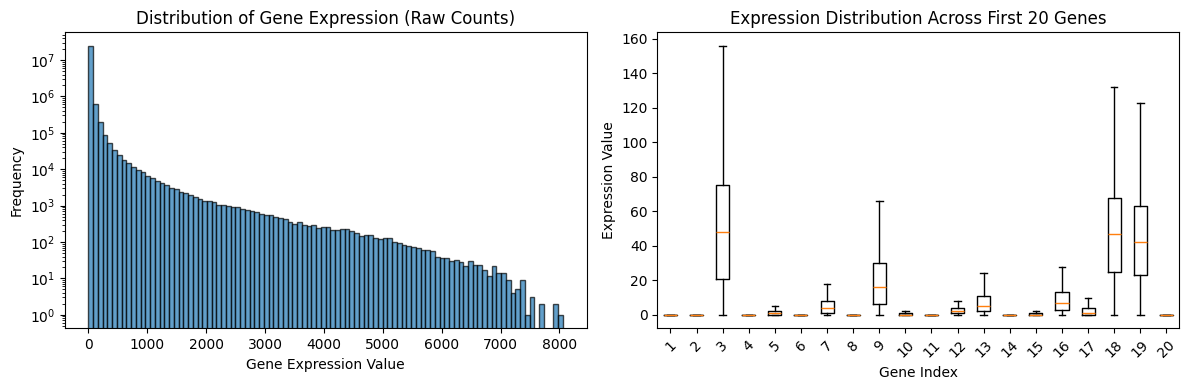

In [28]:
# Explore the distribution of gene expression values
print("Gene expression statistics (before transformation):")
print(f"  Min: {gene_expression_data.min():.2f}")
print(f"  Max: {gene_expression_data.max():.2f}")
print(f"  Mean: {gene_expression_data.mean():.2f}")
print(f"  Median: {np.median(gene_expression_data):.2f}")
print(f"  Std: {gene_expression_data.std():.2f}")

# Check for zeros (important for log transformation)
num_zeros = (gene_expression_data == 0).sum()
print(f"\nNumber of zero values: {num_zeros:,} ({100 * num_zeros / gene_expression_data.size:.2f}% of data)")

# Visualize distribution
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(gene_expression_data.flatten(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Gene Expression Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Gene Expression (Raw Counts)')
axes[0].set_yscale('log')

axes[1].boxplot([gene_expression_data[:, i] for i in range(min(20, gene_expression_data.shape[1]))], 
                showfliers=False)
axes[1].set_xlabel('Gene Index')
axes[1].set_ylabel('Expression Value')
axes[1].set_title('Expression Distribution Across First 20 Genes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Apply Log Transformation

Log transformation is standard in RNA-seq analysis to:
- Normalize the scale of expression values
- Reduce impact of outliers
- Make the distribution more Gaussian-like
- Improve model training (lower loss values)

Gene expression statistics (after log1p transformation):
  Min: 0.00
  Max: 8.99
  Mean: 1.23
  Median: 0.69
  Std: 1.52


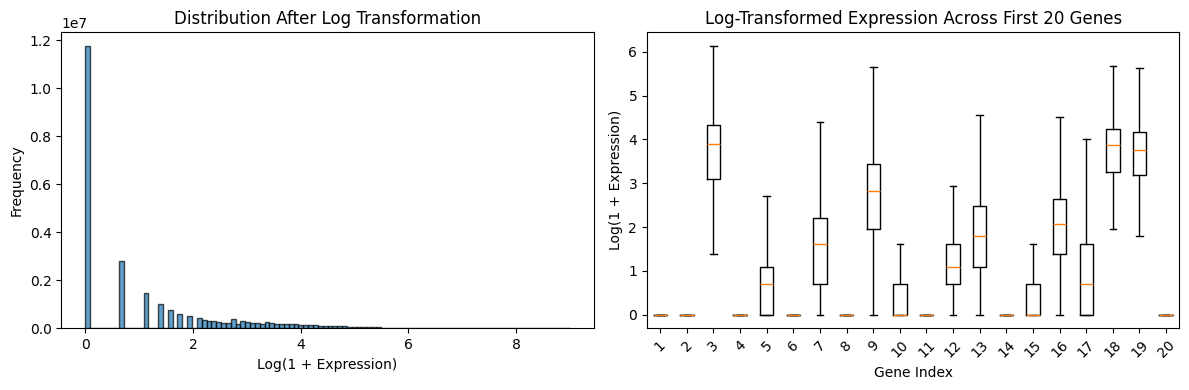


✓ Gene expression data has been log-transformed!
  Shape remains: (7557, 3407)


In [29]:
# Apply log1p transformation (log(1 + x))
# log1p handles zeros gracefully: log(1 + 0) = 0
gene_expression_data_log = np.log1p(gene_expression_data)

print("Gene expression statistics (after log1p transformation):")
print(f"  Min: {gene_expression_data_log.min():.2f}")
print(f"  Max: {gene_expression_data_log.max():.2f}")
print(f"  Mean: {gene_expression_data_log.mean():.2f}")
print(f"  Median: {np.median(gene_expression_data_log):.2f}")
print(f"  Std: {gene_expression_data_log.std():.2f}")

# Visualize transformed distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(gene_expression_data_log.flatten(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Log(1 + Expression)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution After Log Transformation')

axes[1].boxplot([gene_expression_data_log[:, i] for i in range(min(20, gene_expression_data_log.shape[1]))], 
                showfliers=False)
axes[1].set_xlabel('Gene Index')
axes[1].set_ylabel('Log(1 + Expression)')
axes[1].set_title('Log-Transformed Expression Across First 20 Genes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Update the gene_expression_data variable to use log-transformed values
gene_expression_data = gene_expression_data_log
print(f"\n✓ Gene expression data has been log-transformed!")
print(f"  Shape remains: {gene_expression_data.shape}")

## Initialize Model and Training Setup

In [30]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get dimensions
input_dim = drug_features.shape[1]  # Number of molecular features
output_dim = gene_expression_data.shape[1]  # Number of genes

print(f"\nModel configuration:")
print(f"  Input dimension: {input_dim} (molecular descriptors)")
print(f"  Output dimension: {output_dim} (gene expression values)")

# Initialize model
model = SimpleMLP(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dims=[512, 256, 128],  # Three hidden layers
    dropout_rate=0.3
)
model = model.to(device)

print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cpu

Model configuration:
  Input dimension: 2048 (molecular descriptors)
  Output dimension: 3407 (gene expression values)

Model architecture:
SimpleMLP(
  (network): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=3407, bias=True)
  )
)

Total parameters: 1,654,607
Trainable parameters: 1,654,607


In [31]:
# Import the helper functions from our model file
from mlp_model import create_data_loaders, train_epoch, validate

# Create data loaders
train_loader, val_loader, train_idx, val_idx = create_data_loaders(
    drug_features=drug_features,
    gene_expression=gene_expression_data,
    drug_ids=drug_ids,
    train_size=0.8,
    batch_size=32,
    random_state=42
)

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Batches per epoch (train): {len(train_loader)}")
print(f"Batches per epoch (val): {len(val_loader)}")

Training samples: 6045
Validation samples: 1512
Batches per epoch (train): 189
Batches per epoch (val): 48


In [32]:
# Set up training
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Training setup complete!")
print(f"Loss function: MSE Loss")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print(f"Learning rate scheduler: ReduceLROnPlateau")

Training setup complete!
Loss function: MSE Loss
Optimizer: Adam (lr=0.001, weight_decay=1e-5)
Learning rate scheduler: ReduceLROnPlateau


### 📊 Ready to Train!

**Model Summary:**
- Input: 2,048 molecular features (Morgan fingerprints from SMILES)
- Output: 3,407 gene expression values
- Architecture: 2048 → 512 → 256 → 128 → 3407
- Total parameters: ~1.65M
- Training samples: 6,045
- Validation samples: 1,512

The model now uses **real molecular descriptors** generated from SMILES strings! 🎉

## Training Loop

In [33]:
# Training loop
num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Starting training...\n")

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_model.pth')

print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")

Starting training...

Epoch [1/50] | Train Loss: 1.0572 | Val Loss: 0.6571
Epoch [1/50] | Train Loss: 1.0572 | Val Loss: 0.6571
Epoch [5/50] | Train Loss: 0.5040 | Val Loss: 0.5511
Epoch [5/50] | Train Loss: 0.5040 | Val Loss: 0.5511
Epoch [10/50] | Train Loss: 0.4503 | Val Loss: 0.5238
Epoch [10/50] | Train Loss: 0.4503 | Val Loss: 0.5238
Epoch [15/50] | Train Loss: 0.4270 | Val Loss: 0.5456
Epoch [15/50] | Train Loss: 0.4270 | Val Loss: 0.5456
Epoch [20/50] | Train Loss: 0.3974 | Val Loss: 0.5174
Epoch [20/50] | Train Loss: 0.3974 | Val Loss: 0.5174
Epoch [25/50] | Train Loss: 0.3942 | Val Loss: 0.5305
Epoch [25/50] | Train Loss: 0.3942 | Val Loss: 0.5305
Epoch [30/50] | Train Loss: 0.3785 | Val Loss: 0.5245
Epoch [30/50] | Train Loss: 0.3785 | Val Loss: 0.5245
Epoch [35/50] | Train Loss: 0.3716 | Val Loss: 0.5321
Epoch [35/50] | Train Loss: 0.3716 | Val Loss: 0.5321
Epoch [40/50] | Train Loss: 0.3669 | Val Loss: 0.5421
Epoch [40/50] | Train Loss: 0.3669 | Val Loss: 0.5421
Epoch [45/

## Visualize Training Progress

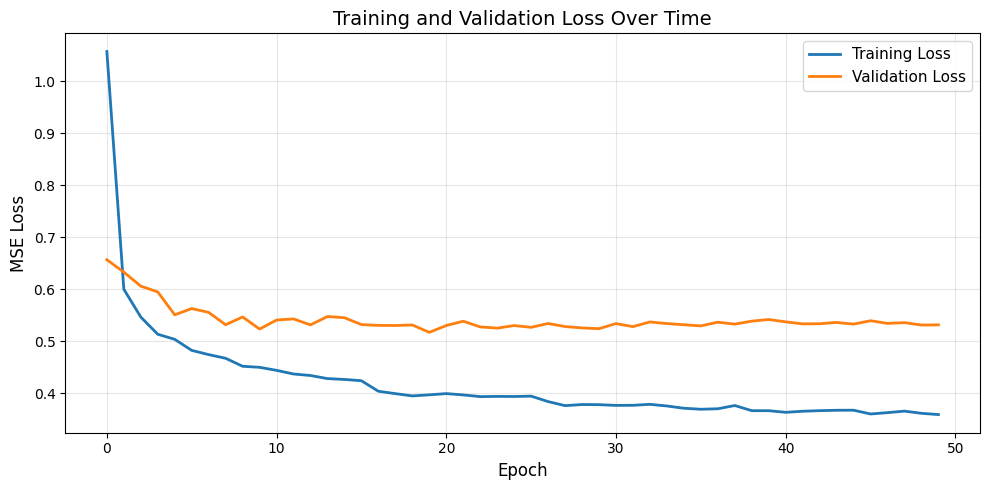

Final training loss: 0.3595
Final validation loss: 0.5319
Best validation loss: 0.5174


In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

## Make Predictions

Test the model on validation data and analyze predictions.

In [35]:
# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Make predictions on validation set
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_data in val_loader:
        # Handle both 2-tuple and 3-tuple returns from dataset
        if len(batch_data) == 3:
            batch_features, batch_targets, _ = batch_data
        else:
            batch_features, batch_targets = batch_data
            
        batch_features = batch_features.to(device)
        predictions = model(batch_features)
        
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(batch_targets.numpy())

# Concatenate all batches
predictions = np.vstack(all_predictions)
targets = np.vstack(all_targets)

print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

# Calculate metrics
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R² and MAE for each gene
r2_scores = [r2_score(targets[:, i], predictions[:, i]) for i in range(targets.shape[1])]
mae_scores = [mean_absolute_error(targets[:, i], predictions[:, i]) for i in range(targets.shape[1])]

print(f"\nOverall metrics:")
print(f"Mean R² score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Median R² score: {np.median(r2_scores):.4f}")
print(f"Best R² score: {np.max(r2_scores):.4f}")

Predictions shape: (1512, 3407)
Targets shape: (1512, 3407)

Overall metrics:
Mean R² score: 0.0644 ± 0.0917
Mean MAE: 0.4663 ± 0.2814
Median R² score: 0.0512
Best R² score: 0.3742

Overall metrics:
Mean R² score: 0.0644 ± 0.0917
Mean MAE: 0.4663 ± 0.2814
Median R² score: 0.0512
Best R² score: 0.3742


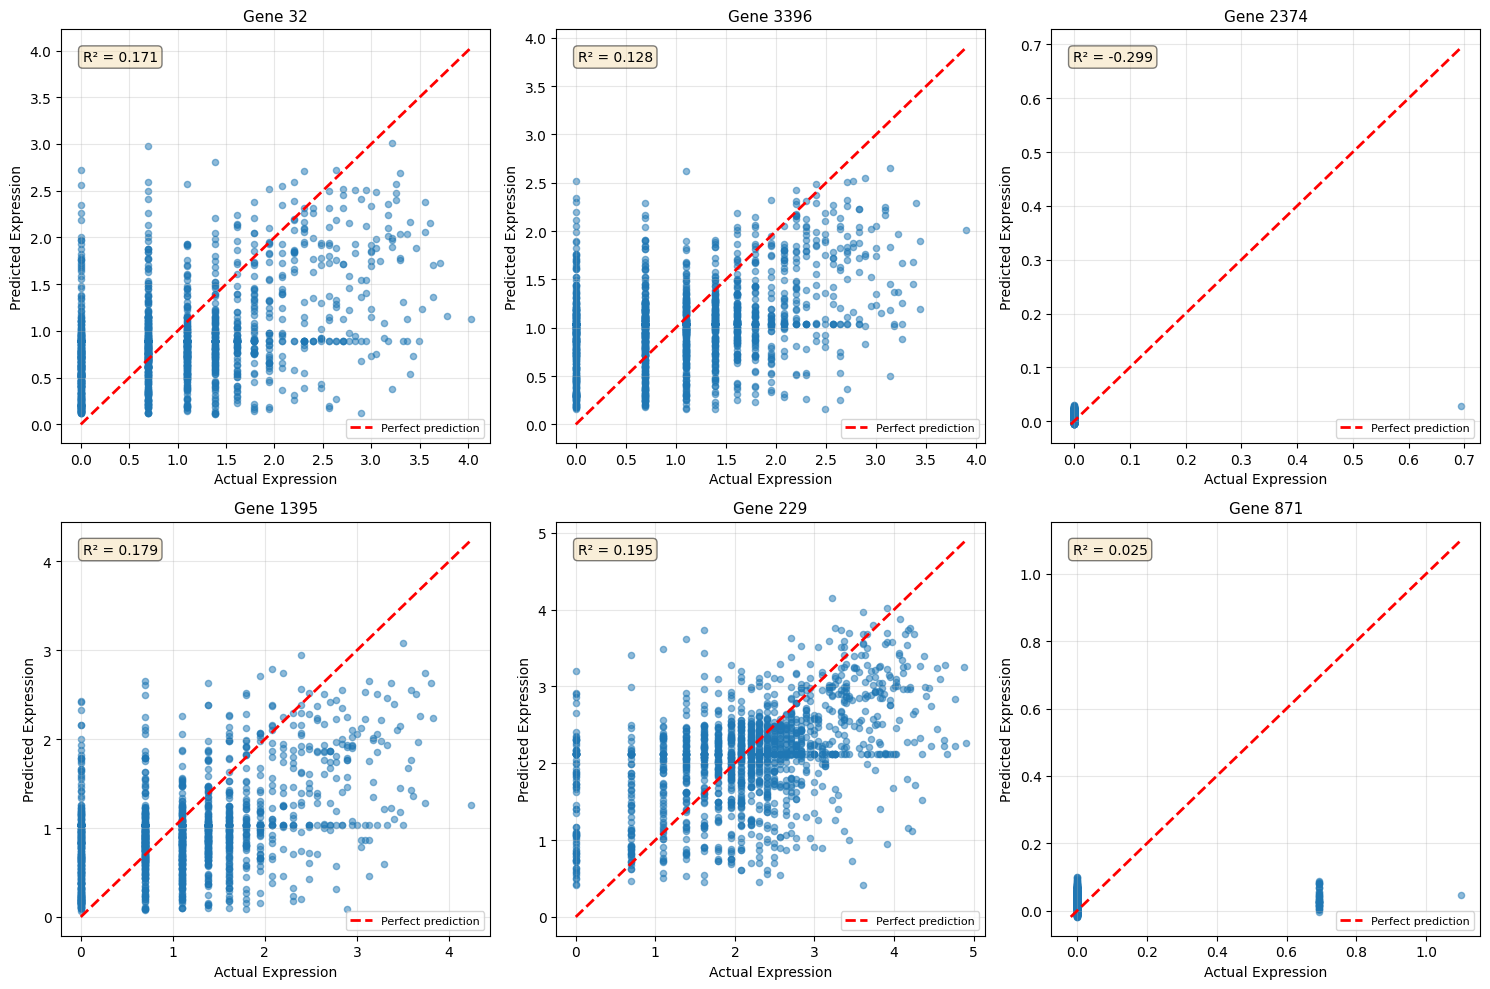

In [36]:
# Visualize predictions vs actual for a sample of genes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select 6 random genes to visualize
np.random.seed(42)
gene_indices = np.random.choice(targets.shape[1], 6, replace=False)

for idx, gene_idx in enumerate(gene_indices):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(targets[:, gene_idx], predictions[:, gene_idx], alpha=0.5, s=20)
    
    # Add perfect prediction line
    min_val = min(targets[:, gene_idx].min(), predictions[:, gene_idx].min())
    max_val = max(targets[:, gene_idx].max(), predictions[:, gene_idx].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    
    # Add R² score
    r2 = r2_score(targets[:, gene_idx], predictions[:, gene_idx])
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual Expression', fontsize=10)
    ax.set_ylabel('Predicted Expression', fontsize=10)
    ax.set_title(f'Gene {gene_idx}', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()